## Setup


This notebook was originally written with the following versions:

    python 3.7.4
    fastai 1.0.57
    torch 1.2.0
    pandas 0.25.0
    numpy 1.16.4

##### Fastai: Useful links and commands to get setup:
Install anaconda3 on Linux (https://docs.anaconda.com/anaconda/install/linux/):

    wget https://repo.anaconda.com/archive/Anaconda3-2019.07-Linux-x86_64.sh
    bash ~/Anaconda3-2019.07-Linux-x86_64.sh

Enter an anaconda environment: 

    source anaconda3/bin/activate
    
Create new anaconda environment: 

    conda create -n myenv python=3.7.4

Enter conda environment:

    conda activate myenv
    
Install fastai + dependencies:

    conda install -c pytorch -c fastai fastai pytorch torchvision cuda92
    
    
##### Library Docs (for reference):
    
- fastai tabular: https://docs.fast.ai/tabular.data.html
- pandas dataframe: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html
    


## Prepare Notebook

In [1]:
# Jupyter Notebook Magic

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import Modules

from fastai.tabular import *
from fastai.collab import *
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy import interp

from ipywidgets import IntProgress
from IPython.display import display

import unittest
import datetime

# Data Information

# filename = 'patient_year_vital_lab_exam_add-on_death_outcome_comorbidity_TCIC_dengue_suspected_bmi_ER_label_missing_mask.csv'
filename = 'patients_cleaned.csv'
path = Path('../mydata')

In [2]:
# PARAMETERS



splits = 5 # number of folds for cross validation
# recalls = [0.85,0.90,0.95] # sensitivities used for calculating results
min_recall = 0.90

# Imported columns from CSV
desired_cols = ['age','sex','Temp','exam_WBC','exam_Plt', 'Opd_Visit_Date',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result']

# Features used for training + dependent variable
train_cols = ['age','Temp','exam_WBC','exam_Plt','lab_result']


# Features used for creating validation subgroups (includes features from train_cols)
subgroup_cols = ['age','sex','Temp','exam_WBC','exam_Plt', 'week',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result']

cont_cols = ['age','Temp','exam_WBC','exam_Plt']
cat_cols = []

# Columns to be dropped after creating validation subgroups
drop_cols = list(set(subgroup_cols) - set(train_cols))

## Data Preparation

#### Convert CSV to Dataframe

In [ ]:
#### View all CSV column names
# df = pd.read_csv(path/filename, low_memory=False)
# "|".join(df.columns.tolist())

In [3]:
# IMPORT DATAFRAME

df = pd.read_csv(path/filename, usecols=desired_cols) # import from csv
df = df.iloc[np.random.permutation(len(df))] # randomize data
df.reset_index(drop=True, inplace=True) # reset index

In [4]:
df.head()

,Opd_Visit_Date,sex,age,Temp,exam_Plt,exam_WBC,CKD,DM,CVA,Hypertension,Heart Disease,Cancer without Metastasis,Cancer with Metastasis,Severe Liver Disease,lab_result,ER
0,2015/8/20,女,71,38.0,221.0,6.7,False,False,False,False,False,True,False,False,True,True
1,2015/10/9,女,33,36.6,155.0,5.8,True,True,False,True,False,False,False,False,False,True
2,2015/9/10,男,29,38.7,83.0,3.0,False,False,False,False,False,True,False,False,True,True
3,2015/9/17,男,75,39.2,137.0,4.0,False,False,False,False,False,False,False,False,True,False
4,2015/9/27,女,70,39.2,61.0,2.8,True,False,True,False,False,False,False,False,True,True


#### Subgroup Creation

In [5]:
# Convert Opd_Visit_Date to week of year format
if 'week' not in df.columns and 'Opd_Visit_Date' in df.columns:
    week_numbers = [int(datetime.datetime.strptime(d, "%Y/%m/%d").strftime("%U"))+1 for d in df['Opd_Visit_Date']]
    df.insert(0, 'week', week_numbers)
    df.drop(columns=['Opd_Visit_Date'],inplace=True)
    
# Convert 男 and 女 to 0 and 1 in column 'sex'
df_male_indx = df[df['sex']=='男']
df_female_indx = df[df['sex']=='女']

for i in df_male_indx.index.tolist():
    df.at[int(i),'sex'] = 0
for i in df_female_indx.index.tolist():
    df.at[int(i),'sex'] = 1

In [6]:
dataframe = df

# Equal length subsets of original dataframe
len_df = len(dataframe)
cut_indices = [int(i*(1/splits)*len_df) for i in range(0,splits+1)]
cut_indices = zip(cut_indices[:-1], cut_indices[1:])
subsets = [dataframe[i:j] for i,j in cut_indices]

valids = subsets
trains = [pd.concat(subsets[1:], axis=0)]
for n in range(1,splits):
    trains += [pd.concat(subsets[:n]+subsets[n+1:], axis=0)]

In [7]:
# some tests
assert len(valids) == len(trains)
assert len(valids[0])+len(trains[0])==len(df)

assert list(valids[1].index) != list(valids[0].index)
assert list(trains[1].index) != list(trains[0].index)

for i in range(len(valids)):
    assert valids[i].index[0] not in trains[i].index
    assert valids[i].index[-1] not in trains[i].index

In [8]:
# Separate Dataframe into Subgroups

frames = [] # temporarily stores dataframes
subgroup_dicts = []

for modelnum in range(1,splits+1):

    dataframe = subsets[modelnum-1] # validation set

    # age
    df_age_under_18 = dataframe[dataframe['age']<18]
    df_age_18_to_65 = dataframe[(dataframe['age']>=18) & (dataframe['age']<65)]
    df_age_over_eq_65 = dataframe[dataframe['age']>=65]

    # sex
    df_female = dataframe[dataframe['sex']==1]
    df_male = dataframe[dataframe['sex']==0]

    # week
    df_wks_35 = dataframe[dataframe['week']<=35]
    df_wks_35_to_40 = dataframe[(dataframe['week']>35) & (dataframe['week']<=40)]
    df_wks_over_40 = dataframe[dataframe['week']>40]

    # Temp
    df_temp_over_eq_38 = dataframe[dataframe['Temp']>=38]
    df_temp_under_38 = dataframe[dataframe['Temp']<38]

    # exam_WBC
    df_wbc_low = dataframe[dataframe['exam_WBC']<=3.2]
    df_wbc_normal = dataframe[(dataframe['exam_WBC']>3.2) & (dataframe['exam_WBC']<10)]
    df_wbc_high = dataframe[dataframe['exam_WBC']>=10]

    # exam_Plt
    df_plt_low = dataframe[dataframe['exam_Plt']<100]
    df_plt_high = dataframe[dataframe['exam_Plt']>=100]

    # Comorbidities
    df_heart_disease = dataframe[dataframe['Heart Disease']==True]
    df_cva = dataframe[dataframe['CVA']==True]
    df_ckd = dataframe[dataframe['CKD']==True]
    df_liver = dataframe[dataframe['Severe Liver Disease']==True]
    df_dm = dataframe[dataframe['DM']==True]
    df_hypertension = dataframe[dataframe['Hypertension']==True]


    df_cancer1 = dataframe[(dataframe['Cancer with Metastasis']==True)]
    df_cancer2 = dataframe[(dataframe['Cancer without Metastasis']==True)]
    df_cancer = pd.concat([df_cancer1, df_cancer2], axis=0)

    df_er = dataframe[dataframe['ER']==True]
    
    overall = dataframe

    frame = [df_age_under_18, df_age_18_to_65, df_age_over_eq_65, df_female, df_male, df_wks_35, df_wks_35_to_40, 
          df_wks_over_40, df_temp_over_eq_38, df_temp_under_38, df_wbc_low, df_wbc_normal, df_wbc_high, 
          df_plt_low, df_plt_high, df_heart_disease, df_cva, df_ckd, df_liver, df_dm, df_hypertension, 
          df_cancer, df_er, overall]

    dfs_names = ['df_age_under_18', 'df_age_18_to_65', 'df_age_over_eq_65', 'df_female', 'df_male', 'df_wks_35', 'df_wks_35_to_40', 
          'df_wks_over_40', 'df_temp_over_eq_38', 'df_temp_under_38', 'df_wbc_low', 'df_wbc_normal', 'df_wbc_high', 
          'df_plt_low', 'df_plt_high', 'df_heart_disease', 'df_cva', 'df_ckd', 'df_liver', 'df_dm', 'df_hypertension', 
          'df_cancer', 'df_er','overall']

    subgroup_dict = {name:frame for (name, frame) in zip(dfs_names, frame)}
    
#     dfs = frame # because of older code... (technical debt)

    # Display Subgroup Sizes

#     print("Dataframes (Model "+str(modelnum)+')'," "*(20-len('dataframes (Model n)')),"| Length", ' ',"| Percent Length")
#     print("-"*50)
#     length = 0
#     for i in range(len(dfs)):
#         print(dfs_names[i],' '*(20-len(dfs_names[i])),'|',len(dfs[i]),' '*(7-len(str(len(dfs[i])))),f'| {100*len(dfs[i])/len(dataframe):0.2f}%')
#         length += len(dfs[i])
        
#     print('-'*42)
#     print('valid_df '+str(modelnum),' '*(20-len('valid_df 1')), '|', len(dataframe),' '*2 ,f' | 100%') 
#     print('\n'*2)

    frames += [frame]
    subgroup_dicts += [subgroup_dict]
    
# RESET DFS

dfs = frames


In [9]:
subgroup_dicts[0]['overall'].head()

,week,sex,age,Temp,exam_Plt,exam_WBC,CKD,DM,CVA,Hypertension,Heart Disease,Cancer without Metastasis,Cancer with Metastasis,Severe Liver Disease,lab_result,ER
0,34,1,71,38.0,221.0,6.7,False,False,False,False,False,True,False,False,True,True
1,41,1,33,36.6,155.0,5.8,True,True,False,True,False,False,False,False,False,True
2,37,0,29,38.7,83.0,3.0,False,False,False,False,False,True,False,False,True,True
3,38,0,75,39.2,137.0,4.0,False,False,False,False,False,False,False,False,True,False
4,40,1,70,39.2,61.0,2.8,True,False,True,False,False,False,False,False,True,True


In [10]:
subgroup_dicts[0]['df_wbc_low'].head()

,week,sex,age,Temp,exam_Plt,exam_WBC,CKD,DM,CVA,Hypertension,Heart Disease,Cancer without Metastasis,Cancer with Metastasis,Severe Liver Disease,lab_result,ER
2,37,0,29,38.7,83.0,3.0,False,False,False,False,False,True,False,False,True,True
4,40,1,70,39.2,61.0,2.8,True,False,True,False,False,False,False,False,True,True
8,37,1,62,37.3,121.0,2.6,False,False,False,False,True,False,False,False,True,True
11,38,0,56,38.8,125.0,3.2,True,False,False,True,False,False,False,False,True,True
13,34,1,67,37.4,111.0,2.4,False,False,False,False,False,False,False,False,True,True


In [11]:
# drop_cols defined in Parameters section

for model_indx in range(len(dfs)):
    dataframes = dfs[model_indx]
    train_df = trains[model_indx]
    valid_df = subsets[model_indx]
    
    
    # Remove columns of unused features in validation subgroups
    for i in range(len(dataframes)):
        if drop_cols[0] in dataframes[i].columns:
            dataframes[i].drop(columns=drop_cols,inplace=True)

    # Remove columns of unused features in training dataset
    if drop_cols[0] in train_df.columns:
        train_df.drop(columns=drop_cols,inplace=True)

    # Remove columns of unused features in full validation dataset
    if drop_cols[0] in valid_df.columns:
        valid_df.drop(columns=drop_cols,inplace=True)

/home/gilbert/anaconda3/envs/econda/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
subgroup_dicts[0]['overall'].head()

,age,Temp,exam_Plt,exam_WBC,lab_result
0,71,38.0,221.0,6.7,True
1,33,36.6,155.0,5.8,False
2,29,38.7,83.0,3.0,True
3,75,39.2,137.0,4.0,True
4,70,39.2,61.0,2.8,True


#### Prepare Fastai Databunch

In [13]:
# Convert dataframe types to float32 for fastai's tabular learner
df.astype('float32')

dep_var = 'lab_result' # target / dependent variable
cat_names = [] # categorical variables
cont_names = ['age','Temp','exam_Plt','exam_WBC'] # continuous variables
# procs = [FillMissing, Categorify, Normalize] # procs didn't work because no categorical variables were used


datas = []

for i in range(splits):
    valid = valids[i]
    train = trains[i]

    valid_indx = np.array(valid.index)
    train_indx = np.array(train.index)
#     df = df[train_cols]
    
    data = TabularDataBunch.from_df(df=df[train_cols], path=path, cat_names=cat_names, cont_names=cont_names,
                                   valid_idx=valid_indx, dep_var=dep_var)
    
#     data = (TabularList.from_df(df=df[train_cols], path=path, cat_names=cat_names, cont_names=cont_names)
#                                .split_by_idxs(train_idx=train_indx, valid_idx=valid_indx)
#                                .label_from_df(cols=dep_var)
#                                .databunch())
    
    datas += [data]

datas[0].show_batch()

age,Temp,exam_Plt,exam_WBC,target
24.0000,39.3000,223.0000,7.4000,True
19.0000,39.0000,130.0000,5.0000,True
22.0000,37.6000,160.0000,1.7000,True
21.0000,37.1000,170.0000,5.3000,True
82.0000,36.7000,19.0000,4.3000,True


In [14]:
actual_valid = pd.concat(list(datas[0].valid_ds.x[:]),axis=1).T # the first actual validation set

# check indices of all desired validation sets against actual_valid
for split in range(splits):
    print(tensor([(idx in valids[split].index) for idx in actual_valid.index]).type(torch.FloatTensor).mean().item())

1.0
0.0
0.0
0.0
0.0


In [16]:
# some tests

# Test data.valid_ds and data.train_ds are as desired
print("Testing that Train and Valid Datasets loaded correctly...")
for s in range(splits):
    print(f"Fold: {s}")
    data = datas[s]
    valid = valids[s]
    train = trains[s]
    
    assert len(valid)+len(train)==len(df)
    assert len(valid) == len(data.valid_ds)
    assert len(train) == len(data.train_ds)
    
    # ensure percent_desired works
    actual_valid_idx = pd.concat(list(data.valid_ds.x[:]),axis=1).T.index # actual indices of data in data.valid_ds
    percent_desired = tensor([(idx in actual_valid_idx) for idx in actual_valid_idx]).type(torch.FloatTensor).mean().item()
    assert percent_desired == 1.
    
    # check that valid == data.valid_ds
    actual_valid_idx = pd.concat(list(data.valid_ds.x[:]),axis=1).T.index # actual indices of data in data.valid_ds
    desired_valid_idx = valid.index # desired indices of data in validation set
    percent_desired = tensor([(idx in actual_valid_idx) for idx in desired_valid_idx]).type(torch.FloatTensor).mean().item()
    assert percent_desired == 1.
    
    # check that train == data.train_ds
    actual_train_idx = pd.concat(list(data.train_ds.x[:]),axis=1).T.index # actual indices of data in data.valid_ds
    desired_train_idx = train.index # desired indices of data in training set
    percent_desired = tensor([(idx in actual_train_idx) for idx in desired_train_idx]).type(torch.FloatTensor).mean().item()
    assert percent_desired == 1.
    
print("Tests Complete: No overlap exists")

Testing that Train and Valid Datasets loaded correctly...
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Tests Complete: No overlap exists


## Training

In [17]:
learners = []

for i in range(splits):
    data = datas[i]
    
    # Train
    learn = tabular_learner(data, layers=[16,16,16],metrics=accuracy) # 200 100
    learn.fit_one_cycle(15,max_lr=1e-3)
    
    learners += [learn]

epoch,train_loss,valid_loss,accuracy,time
0,0.670845,0.637583,0.680982,00:00
1,0.604873,0.553314,0.741309,00:00
2,0.527100,0.489507,0.779141,00:00
3,0.482827,0.470154,0.788344,00:00
4,0.468284,0.462641,0.797546,00:00
5,0.456374,0.460589,0.798568,00:00
6,0.448071,0.460272,0.800614,00:00
7,0.444445,0.458688,0.797546,00:00
8,0.435988,0.457894,0.794479,00:00
9,0.439247,0.459148,0.793456,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.707691,0.682914,0.586313,00:00
1,0.635414,0.573711,0.713994,00:00
2,0.553020,0.498734,0.782431,00:00
3,0.500223,0.471924,0.806946,00:00
4,0.474382,0.451815,0.805924,00:00
5,0.462171,0.446180,0.812053,00:00
6,0.453625,0.441364,0.815117,00:00
7,0.447854,0.442444,0.810010,00:00
8,0.445981,0.439713,0.811032,00:00
9,0.447398,0.439874,0.819203,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.674152,0.625762,0.663943,00:00
1,0.598312,0.526215,0.752809,00:00
2,0.535138,0.485763,0.788560,00:00
3,0.488090,0.468037,0.788560,00:00
4,0.467197,0.465597,0.794688,00:00
5,0.462096,0.461145,0.798774,00:00
6,0.454673,0.458823,0.802860,00:00
7,0.450629,0.463623,0.797753,00:00
8,0.444802,0.456584,0.800817,00:00
9,0.441428,0.458648,0.796731,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.707380,0.664134,0.609806,00:00
1,0.645786,0.559129,0.752809,00:00
2,0.576737,0.483165,0.793667,00:00
3,0.513167,0.444346,0.803882,00:00
4,0.484416,0.430172,0.823289,00:00
5,0.468712,0.430062,0.824311,00:00
6,0.463611,0.424838,0.825332,00:00
7,0.453784,0.425790,0.822268,00:00
8,0.453096,0.426066,0.821246,00:00
9,0.449440,0.423794,0.828396,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.920499,0.842288,0.436159,00:00
1,0.762161,0.626594,0.691522,00:00
2,0.605614,0.501898,0.786517,00:00
3,0.522387,0.470808,0.799796,00:00
4,0.488603,0.455393,0.813075,00:00
5,0.468184,0.449100,0.812053,00:00
6,0.462429,0.443565,0.807967,00:00
7,0.454939,0.444008,0.802860,00:00
8,0.454088,0.444036,0.805924,00:00
9,0.452762,0.444414,0.807967,00:00


## Results

In [18]:
# Get Results

# stuff for confusion matrices
confs = {}

# stuff for ROC curves
tprs = []
fprs = []
tprs_interp = []
base_fpr = np.linspace(0, 1, 101)

for i in range(splits):
    learn = learners[i]
    valid = valids[i]
    train = trains[i]
    
    # Create progress bar
    m = len(dfs[0]) # splits*len(dfs[0])
    progress = IntProgress(max=m)
    progress.description = 'ROC_AUC'
    display(progress)
    
    # Obtain ROC Curve for each Model
    targets = tensor([valid['lab_result'].iloc[row] for row in range(len(valid))]).type(torch.LongTensor)
    preds = tensor([list((learn.predict(valid.iloc[row])[2]).numpy()) for row in range(len(valid))])
    
    score = preds[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(targets, score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    
    tprs += [tpr]
    fprs += [fpr]
    tpr[0] = 0.0
    tprs_interp += [interp(base_fpr, fpr, tpr)] # ensure sizes match
    
    # Obtain Confusion Matrix for each Subgroup
    for subgroup in range(len(dfs[0])):
        data = dfs[i][subgroup] # prepare subgroup data for learn.predict
        name = dfs_names[subgroup]
        targets = subgroup # get targets for subgroup
        
        if name not in confs.keys(): 
            confs[name] = [[0,0,0,0]] # initialize confusion matrix
    
    #     preds, targets = learn.get_preds(DatasetType.Valid)
        targets = tensor([data['lab_result'].iloc[row] for row in range(len(data))]).type(torch.LongTensor)
        
        # Note: index 2 of predict returns the output tensor
#         preds = [learn.predict(row)[2] for row in data]  # <--- readable pseudocode
        preds = tensor([list((learn.predict(valid.iloc[row])[2]).numpy()) for row in range(len(data))])
    
        ###
        # Option 1: np.argmax (no threshold used, can't control sensitivity)
        
#         labels = np.argmax(preds, 1)

#         compare = pd.DataFrame(labels == targets)
#         fi = list(compare[compare[0]==False].index.to_numpy()) # false indices (correct preds)
#         ti = list(compare[compare[0]==True].index.to_numpy()) # true indices (incorrect preds)

#         FN = len(labels[fi][labels[fi]==0]) # false negatives
#         FP = len(labels[fi][labels[fi]==1]) # false positives
#         TN = len(labels[ti][labels[ti]==0]) # true negatives
#         TP = len(labels[ti][labels[ti]==1]) # true positives


        ###
        # Option 2: Use Threshold to control sensitivity with min_recall 
        # (Note: min_recall is declared in Parameters Section)
    
        # Obtain prediction label according to min_recall
        scores = preds[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(targets, scores, pos_label=1)
#         roc_auc = metrics.auc(fpr, tpr)

        precision, recall_val, thresholds = metrics.precision_recall_curve(targets, scores, pos_label=1)
        recall_val = np.asarray(recall_val)
        idx = (np.abs(recall_val - min_recall)).argmin() # Find nearest threshold
        thresh = thresholds[idx]

        predict_label = [1 if pred >= thresh else 0 for pred in range(len(scores))]
        conf_mat = confusion_matrix(targets, predict_label)
        TN, FP, FN, TP = conf_mat.flatten()
        
        ###

        conf = [TN, FP, FN, TP]
        confs[name] += [conf]
        
        # update progress bar
#         progress.description = f"{(progress.value/m)*100:0.0f}%"
        progress.description = f"{name}"
        progress.value += 1
    progress.description = '(Done)'

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

#### Combined ROC Curve

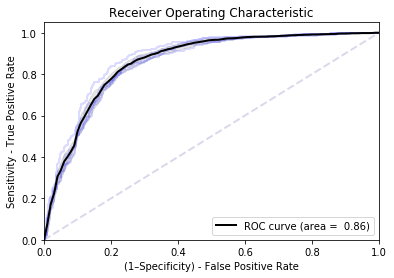

In [19]:
# Create and Save Overall ROC Plot

# path = Path('../mydata/myoutput')
# img_filename = f'NN_dengue_subgroup_analysis_{splits}_fold_ROC.png'

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
# plt.axes().set_aspect('equal', 'datalim')

for s in range(splits):
    fpr = fprs[s]
    tpr = tprs[s]
    plt.plot(fpr, tpr, color='blue',lw=lw, alpha=0.14)

mean_tprs = np.array(tprs_interp).mean(axis=0)
std = np.array(tprs_interp).std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'black', lw=2,label=f'ROC curve (area = {roc_auc: 0.2f})')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)


plt.xlabel('(1–Specificity) - False Positive Rate')
plt.ylabel('Sensitivity - True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# save file
# plt.savefig(path/img_filename, bbox_inches='tight')

plt.show()

In [20]:
confs['overall'][1:]

[[0, 391, 1, 586],
 [0, 385, 1, 593],
 [1, 394, 0, 584],
 [1, 393, 0, 585],
 [0, 387, 1, 591]]

In [21]:
def getacc(conf):
    TN, FP, FN, TP = conf
    if sum(conf) == 0:
        return 0
    else:
        return (TP + TN) / (TP + TN + FP + FN)

In [22]:
[getacc(conf) for conf in confs['overall'][1:]]

[0.5991820040899796,
 0.6057201225740552,
 0.5975485188968335,
 0.5985699693564862,
 0.6036772216547498]

### Compute Results

In [23]:
        
results = [] 

for subgroup in range(len(dfs[0])):
    name = dfs_names[subgroup]
#     confs[name] = list(array(confs[name]).sum(0)) # sum TN, FP, FN, and TP across each model

#     tmp = confs[name][1:]

    conf = list(array(confs[name]).sum(0)) # sum TN, FP, FN, and TP across each model
#     conf = confs[name][2] # <-- this line is for debugging purposes only

    #     print(f"{tmp} --> {conf}")
    TN, FP, FN, TP = conf

    
    PPV = TP / (TP + FP) if (TP+FP != 0) else 0 # positive predict value
    NPV = TN / (TN + FN) if (TN+FN != 0) else 0 # negative predict value
    F1 = 2*TP / (2*TP + FP + FN) #
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP /(TP + FN) if (TP+FN != 0) else 0
    specificity = TN /(TN + FP) if (TN+FP != 0) else 0
    odds_ratio = (TP * TN) /(FP * FN) if (FP*FN != 0) else 0
    total = FN+FP+TN+TP
    
    results += [[name, sensitivity, specificity, accuracy, PPV, NPV, F1, odds_ratio, TN, FP, FN, TP, total]]
    
results_names = ['DF','sensitivity', 'specificity', 'accuracy', 'PPV', 'NPV', 'F1', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'total']

In [24]:
res_df = pd.DataFrame(data=results, columns=results_names)

In [25]:
res_df

,DF,sensitivity,specificity,accuracy,PPV,NPV,F1,odds_ratio,TN,FP,FN,TP,total
0,df_age_under_18,0.988506,0.016393,0.490196,0.488636,0.6,0.653992,1.433333,3,180,2,172,357
1,df_age_18_to_65,0.998931,0.002171,0.575469,0.575431,0.6,0.730221,2.032995,3,1379,2,1869,3253
2,df_age_over_eq_65,0.994426,0.000000,0.694704,0.697420,0.0,0.819853,0.000000,0,387,5,892,1284
3,df_female,0.997284,0.001058,0.607940,0.608786,0.2,0.756047,0.389036,1,944,4,1469,2418
4,df_male,0.997958,0.001986,0.592892,0.593282,0.4,0.744162,0.972471,2,1005,3,1466,2476
5,df_wks_35,0.989975,0.006667,0.721311,0.726103,0.2,0.837752,0.662752,1,149,4,395,549
6,df_wks_35_to_40,0.997908,0.000929,0.638675,0.639410,0.2,0.779412,0.443309,1,1076,4,1908,2989
7,df_wks_over_40,0.996830,0.004138,0.466077,0.465581,0.6,0.634712,1.306787,3,722,2,629,1356
8,df_temp_over_eq_38,0.998510,0.001929,0.659784,0.660210,0.4,0.794862,1.295330,2,1035,3,2011,3051
9,df_temp_under_38,0.998922,0.004372,0.505155,0.504353,0.8,0.670282,4.070252,4,911,1,927,1843


## Using argmax instead of threshold:

In [26]:
# Get Results

confs = {}

tprs = []
fprs = []
tprs_interp = []
base_fpr = np.linspace(0, 1, 101)

for i in range(splits):
    learn = learners[i]
    valid = valids[i]
    train = trains[i]
    
    # Create progress bar
    m = len(dfs[0]) # splits*len(dfs[0])
    progress = IntProgress(max=m)
    progress.description = 'Running...'
    display(progress)
    
#     # Obtain ROC Curve for each Model
#     targets = tensor([valid['lab_result'].iloc[row] for row in range(len(valid))]).type(torch.LongTensor)
#     preds = tensor([list((learn.predict(valid.iloc[row])[2]).numpy()) for row in range(len(valid))])
    
#     score = preds[:,1]
#     fpr, tpr, thresholds = metrics.roc_curve(targets, score, pos_label=1)
#     roc_auc = metrics.auc(fpr, tpr)
    
#     tprs += [tpr]
#     fprs += [fpr]
#     tpr[0] = 0.0
#     tprs_interp += [interp(base_fpr, fpr, tpr)]
    
    # Obtain Confusion Matrix for each Subgroup
    for subgroup in range(len(dfs[0])):
        data = dfs[i][subgroup] # prepare subgroup data for learn.predict
        name = dfs_names[subgroup]
        targets = subgroup # get targets for subgroup
        
        if name not in confs.keys(): 
            confs[name] = [[0,0,0,0]] # initialize confusion matrix
    
    #     preds, targets = learn.get_preds(DatasetType.Valid)
        targets = tensor([data['lab_result'].iloc[row] for row in range(len(data))]).type(torch.LongTensor)
        
        # Note: index 2 of predict returns the output tensor
#         preds = [learn.predict(row)[2] for row in data]  # <--- readable pseudocode
        preds = tensor([list((learn.predict(valid.iloc[row])[2]).numpy()) for row in range(len(data))])
    
        ###
        # Option 1: np.argmax (no threshold used, can't control sensitivity)
        
        labels = np.argmax(preds, 1)

        compare = pd.DataFrame(labels == targets)
        fi = list(compare[compare[0]==False].index.to_numpy()) # false indices (correct preds)
        ti = list(compare[compare[0]==True].index.to_numpy()) # true indices (incorrect preds)

        FN = len(labels[fi][labels[fi]==0]) # false negatives
        FP = len(labels[fi][labels[fi]==1]) # false positives
        TN = len(labels[ti][labels[ti]==0]) # true negatives
        TP = len(labels[ti][labels[ti]==1]) # true positives


#         ###
#         # Option 2: Use Threshold to control sensitivity with min_recall 
#         # (Note: min_recall is declared in Parameters Section)
    
#         # Obtain prediction label according to min_recall
#         scores = preds[:,1]
#         fpr, tpr, thresholds = metrics.roc_curve(targets, scores, pos_label=1)
# #         roc_auc = metrics.auc(fpr, tpr)

#         precision, recall_val, thresholds = metrics.precision_recall_curve(targets, scores, pos_label=1)
#         recall_val = np.asarray(recall_val)
#         idx = (np.abs(recall_val - min_recall)).argmin() # Find nearest threshold
#         thresh = thresholds[idx]

#         predict_label = [1 if pred >= thresh else 0 for pred in range(len(scores))]
#         conf_mat = confusion_matrix(targets, predict_label)
#         TN, FP, FN, TP = conf_mat.flatten()
        
#         ###

        conf = [TN, FP, FN, TP]
        confs[name] += [conf]
        
        # update progress bar
#         progress.description = f"{(progress.value/m)*100:0.0f}%"
        progress.description = f"{name}"
        progress.value += 1
    progress.description = '(Done)'

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

IntProgress(value=0, description='ROC_AUC', max=24)

In [30]:
        
results = [] 

for subgroup in range(len(dfs[0])):
    name = dfs_names[subgroup]
#     confs[name] = list(array(confs[name]).sum(0)) # sum TN, FP, FN, and TP across each model

#     tmp = confs[name][1:]

    conf = list(array(confs[name]).sum(0)) # sum TN, FP, FN, and TP across each model
#     conf = confs[name][2] # <-- this line is for debugging purposes only

    #     print(f"{tmp} --> {conf}")
    TN, FP, FN, TP = conf

    
    PPV = TP / (TP + FP) if (TP+FP != 0) else 0 # positive predict value
    NPV = TN / (TN + FN) if (TN+FN != 0) else 0 # negative predict value
    F1 = 2*TP / (2*TP + FP + FN) #
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP /(TP + FN) if (TP+FN != 0) else 0
    specificity = TN /(TN + FP) if (TN+FP != 0) else 0
    odds_ratio = (TP * TN) /(FP * FN) if (FP*FN != 0) else 0
    total = FN+FP+TN+TP
    
    results += [[name, sensitivity, specificity, accuracy, PPV, NPV, F1, odds_ratio, TN, FP, FN, TP, total]]
    
results_names = ['DF','sensitivity', 'specificity', 'accuracy', 'PPV', 'NPV', 'F1', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'total']

In [31]:
res_df = pd.DataFrame(data=results, columns=results_names)

In [32]:
res_df

,DF,sensitivity,specificity,accuracy,PPV,NPV,F1,odds_ratio,TN,FP,FN,TP,total
0,df_age_under_18,0.655172,0.387978,0.518207,0.504425,0.541985,0.570000,1.204464,71,112,60,114,357
1,df_age_18_to_65,0.646713,0.331404,0.512757,0.567010,0.409294,0.604245,0.907355,458,924,661,1210,3253
2,df_age_over_eq_65,0.636566,0.299742,0.535047,0.678147,0.262443,0.656699,0.749734,116,271,326,571,1284
3,df_female,0.655126,0.340741,0.532258,0.607683,0.387952,0.630513,0.981819,322,623,508,965,2418
4,df_male,0.660313,0.348560,0.533522,0.596556,0.412941,0.626817,1.040098,351,656,499,970,2476
5,df_wks_35,0.659148,0.380000,0.582878,0.738764,0.295337,0.696689,1.185247,57,93,136,263,549
6,df_wks_35_to_40,0.652720,0.337047,0.538976,0.636086,0.353457,0.644295,0.955553,363,714,664,1248,2989
7,df_wks_over_40,0.648177,0.336552,0.481563,0.459551,0.523605,0.537804,0.934577,244,481,222,409,1356
8,df_temp_over_eq_38,0.642999,0.321119,0.533596,0.647824,0.316540,0.645402,0.851947,333,704,719,1295,3051
9,df_temp_under_38,0.646552,0.336612,0.492675,0.497100,0.484277,0.562061,0.928195,308,607,328,600,1843


## Conclusion Stuff

In [25]:
res_df # threshold, recall = 0.9

,DF,sensitivity,specificity,accuracy,PPV,NPV,F1,odds_ratio,TN,FP,FN,TP,total
0,df_age_under_18,0.988506,0.016393,0.490196,0.488636,0.6,0.653992,1.433333,3,180,2,172,357
1,df_age_18_to_65,0.998931,0.002171,0.575469,0.575431,0.6,0.730221,2.032995,3,1379,2,1869,3253
2,df_age_over_eq_65,0.994426,0.000000,0.694704,0.697420,0.0,0.819853,0.000000,0,387,5,892,1284
3,df_female,0.997284,0.001058,0.607940,0.608786,0.2,0.756047,0.389036,1,944,4,1469,2418
4,df_male,0.997958,0.001986,0.592892,0.593282,0.4,0.744162,0.972471,2,1005,3,1466,2476
5,df_wks_35,0.989975,0.006667,0.721311,0.726103,0.2,0.837752,0.662752,1,149,4,395,549
6,df_wks_35_to_40,0.997908,0.000929,0.638675,0.639410,0.2,0.779412,0.443309,1,1076,4,1908,2989
7,df_wks_over_40,0.996830,0.004138,0.466077,0.465581,0.6,0.634712,1.306787,3,722,2,629,1356
8,df_temp_over_eq_38,0.998510,0.001929,0.659784,0.660210,0.4,0.794862,1.295330,2,1035,3,2011,3051
9,df_temp_under_38,0.998922,0.004372,0.505155,0.504353,0.8,0.670282,4.070252,4,911,1,927,1843


In [32]:
res_df # np.argmax()

,DF,sensitivity,specificity,accuracy,PPV,NPV,F1,odds_ratio,TN,FP,FN,TP,total
0,df_age_under_18,0.655172,0.387978,0.518207,0.504425,0.541985,0.570000,1.204464,71,112,60,114,357
1,df_age_18_to_65,0.646713,0.331404,0.512757,0.567010,0.409294,0.604245,0.907355,458,924,661,1210,3253
2,df_age_over_eq_65,0.636566,0.299742,0.535047,0.678147,0.262443,0.656699,0.749734,116,271,326,571,1284
3,df_female,0.655126,0.340741,0.532258,0.607683,0.387952,0.630513,0.981819,322,623,508,965,2418
4,df_male,0.660313,0.348560,0.533522,0.596556,0.412941,0.626817,1.040098,351,656,499,970,2476
5,df_wks_35,0.659148,0.380000,0.582878,0.738764,0.295337,0.696689,1.185247,57,93,136,263,549
6,df_wks_35_to_40,0.652720,0.337047,0.538976,0.636086,0.353457,0.644295,0.955553,363,714,664,1248,2989
7,df_wks_over_40,0.648177,0.336552,0.481563,0.459551,0.523605,0.537804,0.934577,244,481,222,409,1356
8,df_temp_over_eq_38,0.642999,0.321119,0.533596,0.647824,0.316540,0.645402,0.851947,333,704,719,1295,3051
9,df_temp_under_38,0.646552,0.336612,0.492675,0.497100,0.484277,0.562061,0.928195,308,607,328,600,1843


The Fastai tabular learner network has the following architecture:

    (embeds): ModuleList()
      (emb_drop): Dropout(p=0.0, inplace=False)
      (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers): Sequential(
        (0): Linear(in_features=4, out_features=200, bias=True)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=200, out_features=100, bias=True)
        (4): ReLU(inplace=True)
        (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_features=100, out_features=2, bias=True)
      )
    ), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of CrossEntropyLoss(), metrics=[<function accuracy at 0x7f50893ad560>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('../mydata'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=[], layer_groups=[Sequential(
      (0): ModuleList()
      (1): Dropout(p=0.0, inplace=False)
      (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=4, out_features=200, bias=True)
      (4): ReLU(inplace=True)
      (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=200, out_features=100, bias=True)
      (7): ReLU(inplace=True)
      (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Linear(in_features=100, out_features=2, bias=True)
    )]